In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
df = pd.read_pickle("../data/df.pickle")

In [3]:
"""Note
データセットの分割
lockdown(2020/4/1~2020/5/31)
2020/6/1~2020/10/31
2020/11/1~2020/11/30
2020/12/1~2020/12/31
2021/1/1~2021/12/31
2022/1/1~2022/12/31
2023/1/1~2023/9/30
"""

# データセットの分割
df_lockdown = df[(df["started_at"] >= "2020-04-01") & (df["started_at"] <= "2020-05-31")]
df_202006_202010 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] <= "2020-10-31")]
df_202011 = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] <= "2020-11-30")]
df_202012 = df[(df["started_at"] >= "2020-12-01") & (df["started_at"] <= "2020-12-31")]
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] <= "2021-12-31")]
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] <= "2022-12-31")]
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] <= "2023-09-30")]

In [3]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [4]:
# activity distribution
def rho(a, alpha, beta):
    return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)

In [16]:
"""Note 
各データセットについて、それぞれalphaとbetaを推定する
推定したalphaとbetaは、alpha_listとbeta_listに格納する
"""
alpha_list = []
beta_list = []
df_list = [df_lockdown, df_202006_202010, df_202011, df_202012, df_2021, df_2022, df_2023]
Np_list = [596, 673, 677, 677, 846, 1416,1416]

In [6]:
label_list = ["Lockdown", "2020/6/1~2020/10/31", "2020/11/1~2020/11/30", "2020/12/1~2020/12/31", "2021/1/1~2021/12/31", "2022/1/1~2022/12/31", "2023/1/1~2023/9/30"]

In [18]:
a = np.arange(0, 1, 0.01)

plt.figure(figsize=(14, 7))
for i in range(len(df_list)):
    plt.plot(a, rho(a, alpha_list[i], beta_list[i]), label=label_list[i], linewidth=1)
plt.xlabel("Activity")
plt.ylabel("Probability")
plt.legend()
plt.savefig("../fig/alpha_beta.png")
plt.show()

IndexError: list index out of range

<Figure size 1400x700 with 0 Axes>

In [5]:
def getNetworkAnalysis(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df = df.sort_values(by='start_station_name')

    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # ユニークな駅のリストを取得
        # values.ravel('K')で多次元配列を1次元配列に変換
        unique_stations = pd.unique(df_tmp[['start_station_name', 'end_station_name']].values.ravel('K'))

        # node_listにノード数を追加
        node_list.append(len(unique_stations))

        # edge_listにエッジ数を追加
        df_tmp = df_tmp.drop_duplicates(subset=['start_station_name', 'end_station_name'])
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp


In [9]:
node_lockdown2, edge_lockdown2, timestamp_lockdown2 = getNetworkAnalysis(df_lockdown)
node_202006_2020102, edge_202006_2020102, timestamp_202006_2020102 = getNetworkAnalysis(df_202006_202010)
node_2020112, edge_2020112, timestamp_2020112 = getNetworkAnalysis(df_202011)
node_2020122, edge_2020122, timestamp_2020122 = getNetworkAnalysis(df_202012)
node_20212, edge_20212, timestamp_20212 = getNetworkAnalysis(df_2021)
node_20222, edge_20222, timestamp_20222 = getNetworkAnalysis(df_2022)
node_20232, edge_20232, timestamp_20232 = getNetworkAnalysis(df_2023)


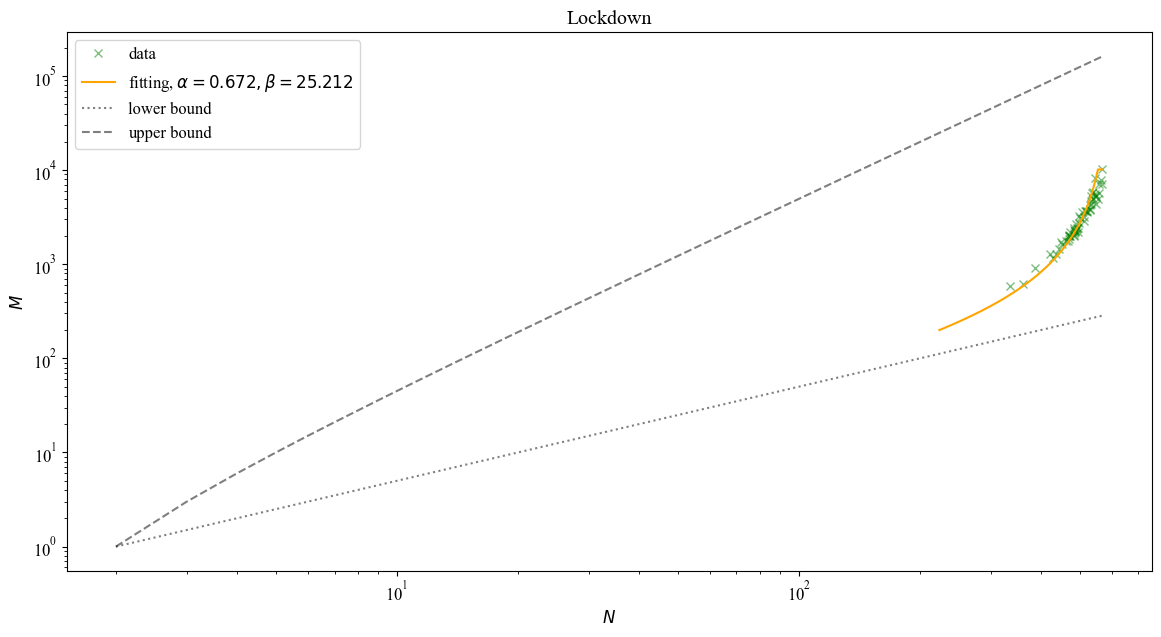

In [94]:
plt.figure(figsize=(14,7))

N = node_lockdown2
M = edge_lockdown2
Np = Np_list[0] # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
plt.title("Lockdown")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

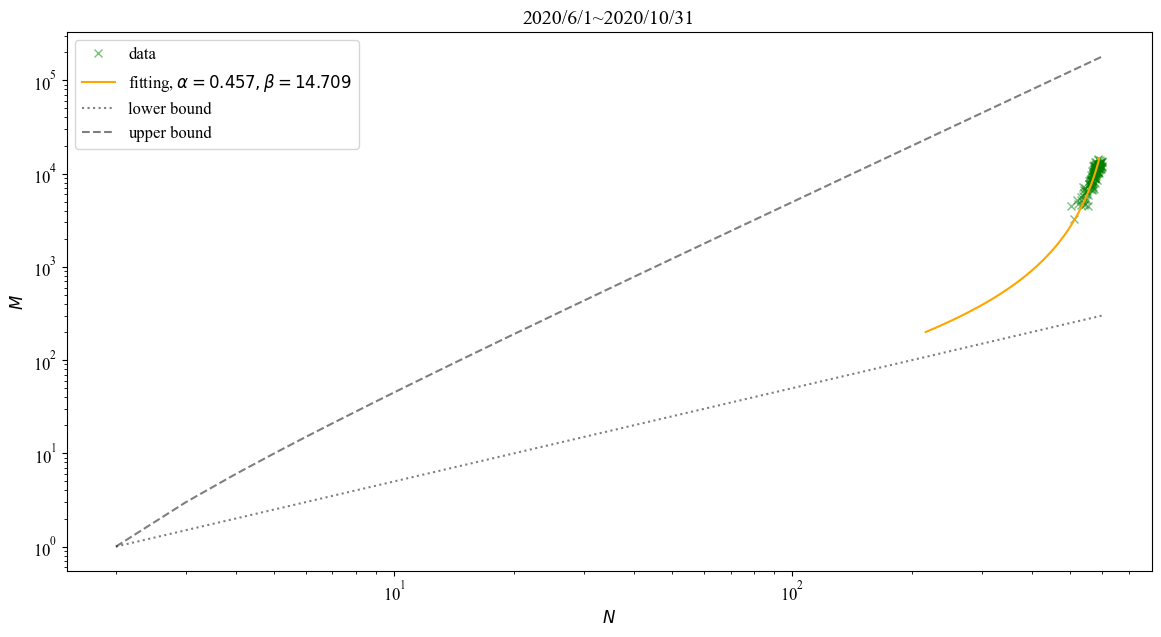

In [96]:
plt.figure(figsize=(14,7))

N = node_202006_2020102
M = edge_202006_2020102
Np = Np_list[1] # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
plt.title("2020/6/1~2020/10/31")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

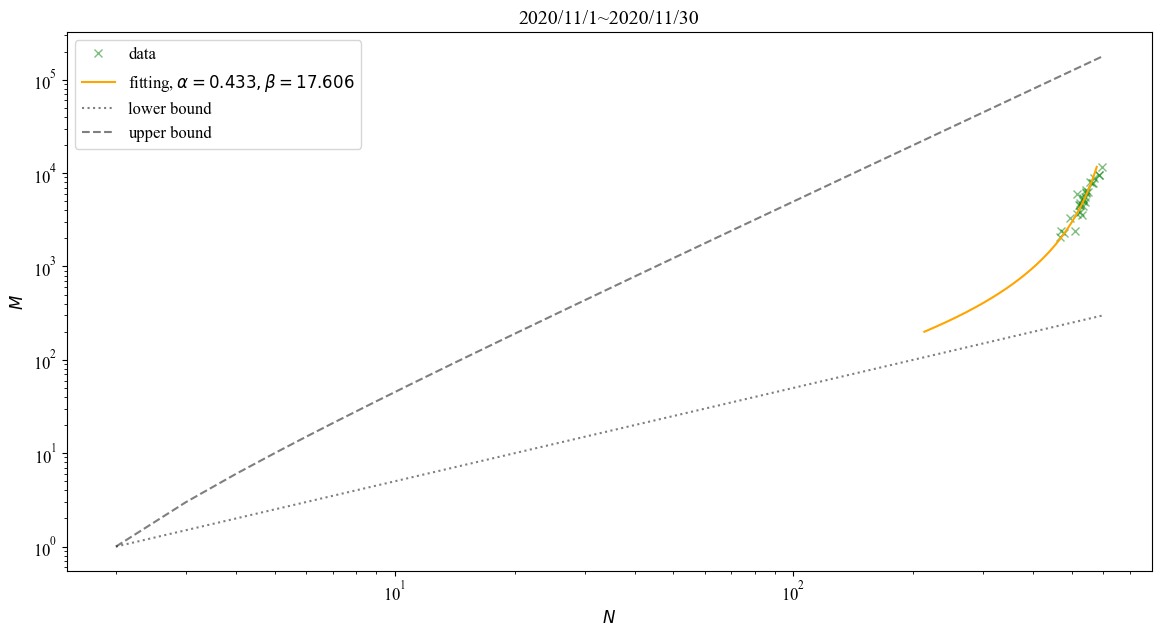

In [99]:
plt.figure(figsize=(14,7))

N = node_2020112
M = edge_2020112
Np = Np_list[2] # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
plt.title("2020/11/1~2020/11/30")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

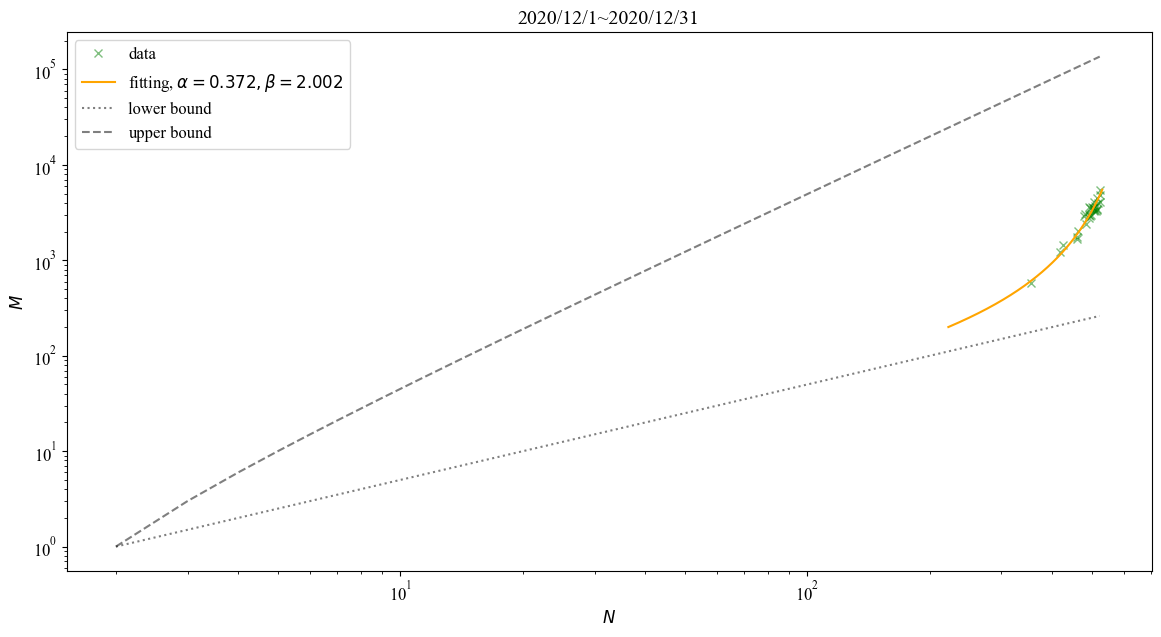

In [112]:
plt.figure(figsize=(14,7))

N = node_2020122
M = edge_2020122
Np = Np_list[3] # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[0.5, 0.5])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
plt.title("2020/12/1~2020/12/31")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

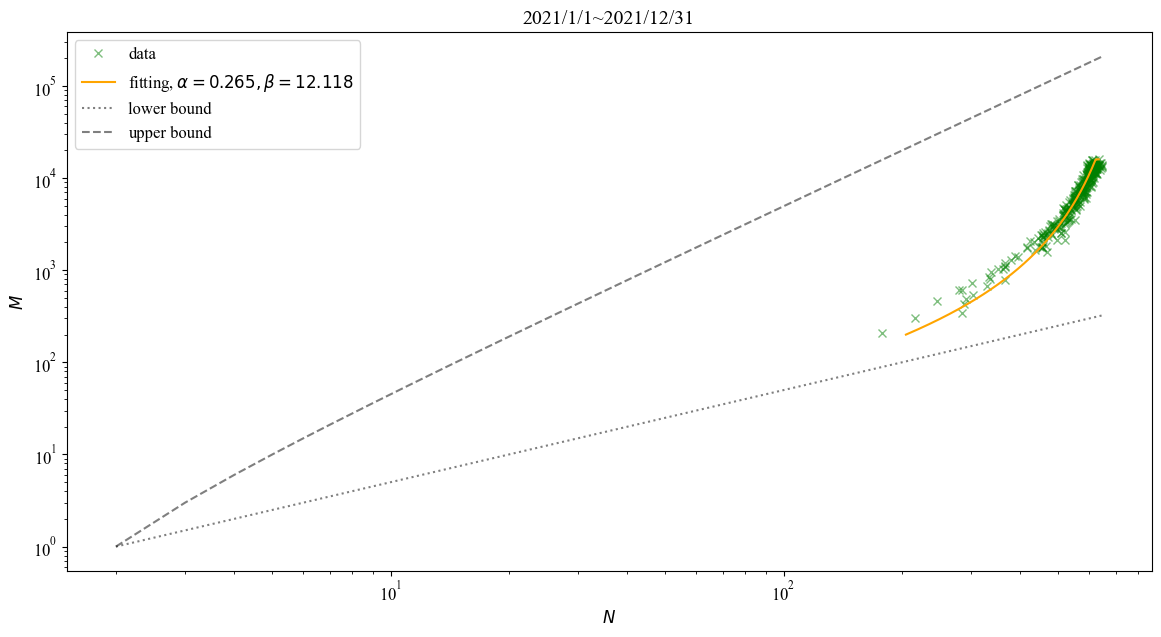

In [100]:
plt.figure(figsize=(14,7))

N = node_20212
M = edge_20212
Np = Np_list[4] # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
plt.title("2021/1/1~2021/12/31")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

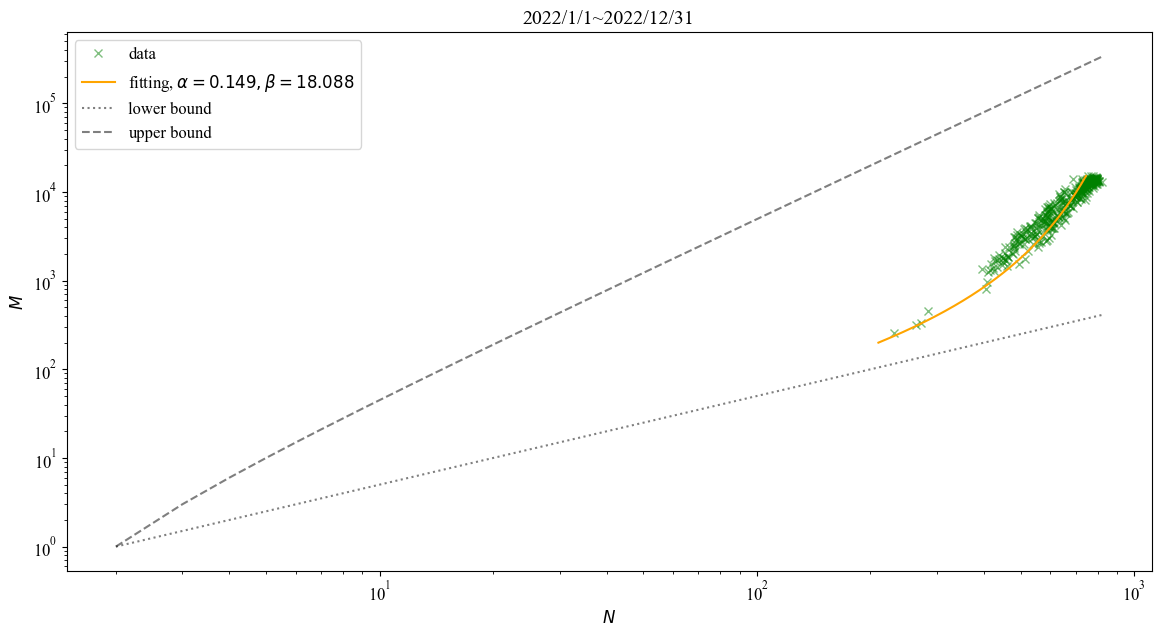

In [103]:
plt.figure(figsize=(14,7))

N = node_20222
M = edge_20222
Np = 1419 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
plt.title("2022/1/1~2022/12/31")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

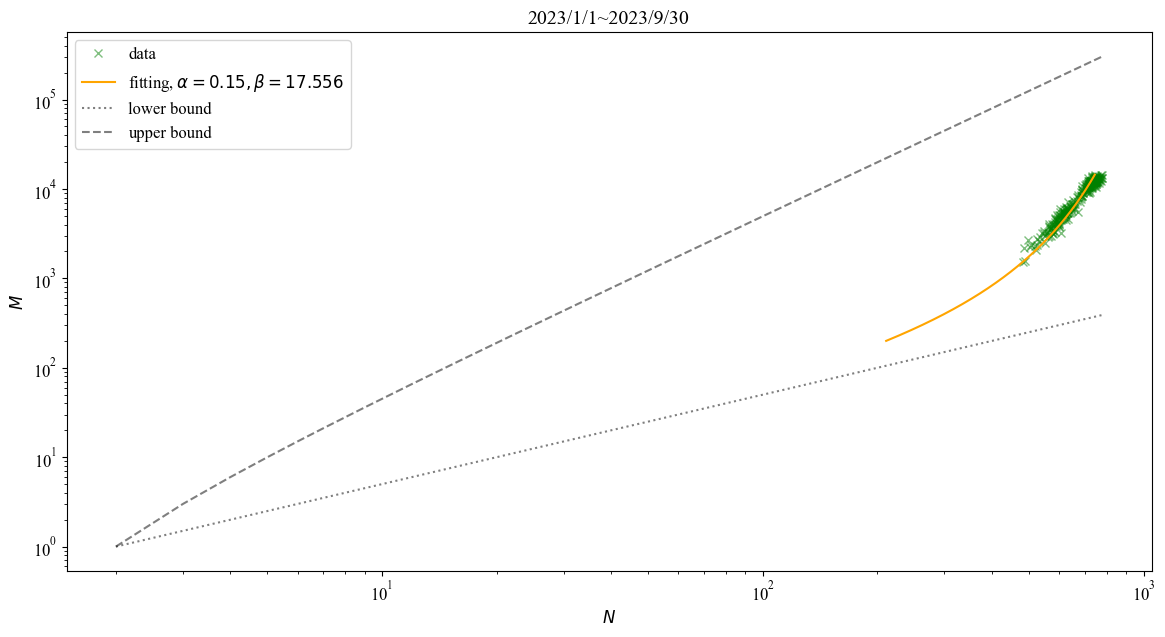

In [101]:
plt.figure(figsize=(14,7))

N = node_20232
M = edge_20232
Np = 1419 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
plt.title("2023/1/1~2023/9/30")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

In [19]:
"""Note 
各データセットについて、それぞれalphaとbetaを推定する
推定したalphaとbetaは、alpha_listとbeta_listに格納する
"""
alpha_list = []
beta_list = []
df_list = [df_lockdown, df_202006_202010, df_202011, df_202012, df_2021, df_2022, df_2023]
node_list = [node_lockdown2, node_202006_2020102, node_2020112, node_2020122, node_20212, node_20222, node_20232]
edge_list = [edge_lockdown2, edge_202006_2020102, edge_2020112, edge_2020122, edge_20212, edge_20222, edge_20232]
Np_list = [596, 673, 677, 677, 846, 1416,1416]

for i in range(len(df_list)):
    Np = Np_list[i]
    N = node_list[i]
    M = edge_list[i]
    df = df_list[i]
    # alphaとbetaの推定
    params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
    alpha_list.append(params[0])
    beta_list.append(params[1])

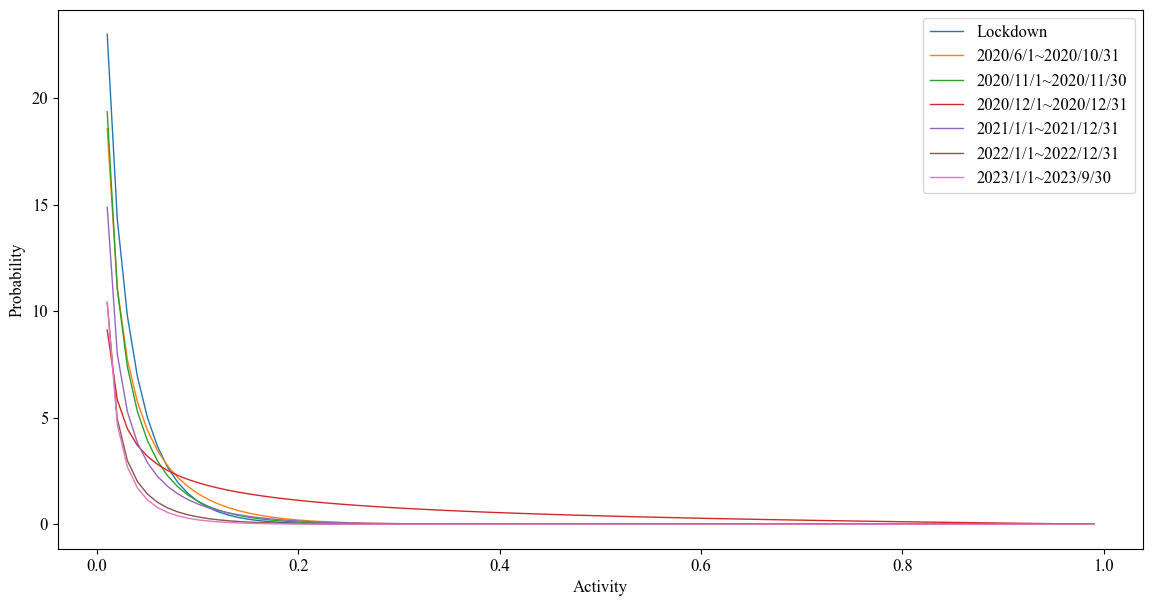

In [20]:
a = np.arange(0, 1, 0.01)

plt.figure(figsize=(14, 7))
for i in range(len(df_list)):
    plt.plot(a, rho(a, alpha_list[i], beta_list[i]), label=label_list[i], linewidth=1)
plt.xlabel("Activity")
plt.ylabel("Probability")
plt.legend()
plt.savefig("../fig/alpha_beta.png")
plt.show()

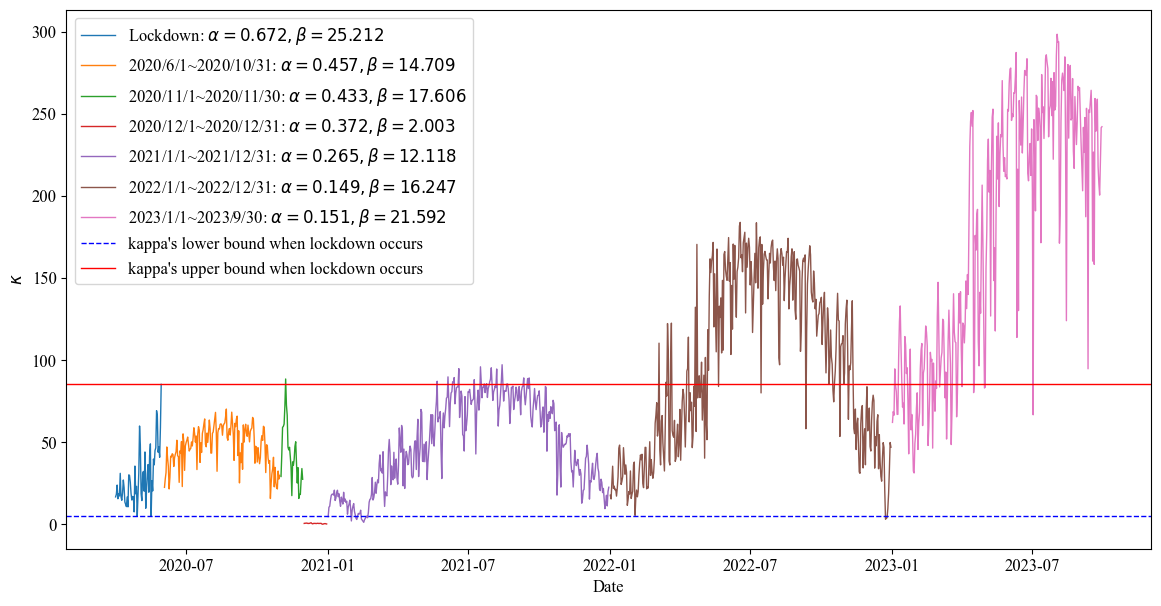

In [38]:
kappa_lockdown2 = []
for i in range(len(edge_lockdown2)):
    alpha = alpha_list[0]
    beta = beta_list[0]
    Np = Np_list[0]
    kappa_lockdown2.append(kappa(edge_lockdown2[i], Np))

kappa_202006_2020102 = []
for i in range(len(edge_202006_2020102)):
    alpha = alpha_list[1]
    beta = beta_list[1]
    Np = Np_list[1]
    kappa_202006_2020102.append(kappa(edge_202006_2020102[i], Np))

kappa_2020112 = []
for i in range(len(edge_2020112)):
    alpha = alpha_list[2]
    beta = beta_list[2]
    Np = Np_list[2]
    kappa_2020112.append(kappa(edge_2020112[i], Np))

kappa_2020122 = []
for i in range(len(edge_2020122)):
    alpha = alpha_list[3]
    beta = beta_list[3]
    Np = Np_list[3]
    kappa_2020122.append(kappa(edge_2020122[i], Np))

kappa_20212 = []
for i in range(len(edge_20212)):
    alpha = alpha_list[4]
    beta = beta_list[4]
    Np = Np_list[4]
    kappa_20212.append(kappa(edge_20212[i], Np))

kappa_20222 = []
for i in range(len(edge_20222)):
    alpha = alpha_list[5]
    beta = beta_list[5]
    Np = Np_list[5]
    kappa_20222.append(kappa(edge_20222[i], Np))

kappa_20232 = []
for i in range(len(edge_20232)):
    alpha = alpha_list[6]
    beta = beta_list[6]
    Np = Np_list[6]
    kappa_20232.append(kappa(edge_20232[i], Np))

# kappaを重ねてみる
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(timestamp_lockdown2, kappa_lockdown2, label=f"Lockdown: $\\alpha={round(alpha_list[0], 3)}, \\beta={round(beta_list[0], 3)}$", linewidth=1)
plt.plot(timestamp_202006_2020102, kappa_202006_2020102, label=f"2020/6/1~2020/10/31: $\\alpha={round(alpha_list[1], 3)}, \\beta={round(beta_list[1], 3)}$", linewidth=1)
plt.plot(timestamp_2020112, kappa_2020112, label=f"2020/11/1~2020/11/30: $\\alpha={round(alpha_list[2], 3)}, \\beta={round(beta_list[2], 3)}$", linewidth=1)
plt.plot(timestamp_2020122, kappa_2020122, label=f"2020/12/1~2020/12/31: $\\alpha={round(alpha_list[3], 3)}, \\beta={round(beta_list[3], 3)}$", linewidth=1)
plt.plot(timestamp_20212, kappa_20212, label=f"2021/1/1~2021/12/31: $\\alpha={round(alpha_list[4], 3)}, \\beta={round(beta_list[4], 3)}$", linewidth=1)
plt.plot(timestamp_20222, kappa_20222, label=f"2022/1/1~2022/12/31: $\\alpha={round(alpha_list[5], 3)}, \\beta={round(beta_list[5], 3)}$", linewidth=1)
plt.plot(timestamp_20232, kappa_20232, label=f"2023/1/1~2023/9/30: $\\alpha={round(alpha_list[6], 3)}, \\beta={round(beta_list[6], 3)}$", linewidth=1)

# lockdownの上限と下限の値で線を引く
plt.axhline(y=np.min(kappa_lockdown2), color="blue", linestyle="--", linewidth=1, label="kappa's lower bound when lockdown occurs")
plt.axhline(y=np.max(kappa_lockdown2), color="red", linestyle="-", linewidth=1, label="kappa's upper bound when lockdown occurs")


plt.xlabel("Date")
plt.ylabel(r"$\kappa$")
plt.legend()
plt.savefig("../fig/kappa.png")
plt.show()


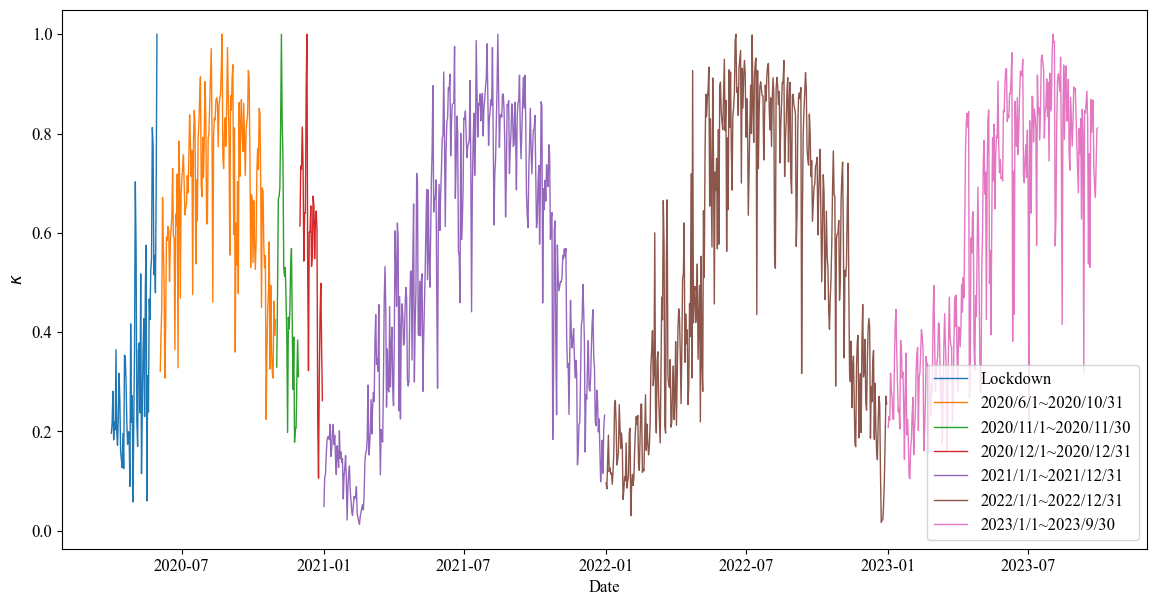

In [118]:
# kappaを100で正規化する
kappa_lockdown3 = kappa_lockdown2/np.max(kappa_lockdown2)
kappa_202006_2020103 = kappa_202006_2020102/np.max(kappa_202006_2020102)
kappa_2020113 = kappa_2020112/np.max(kappa_2020112)
kappa_2020123 = kappa_2020122/np.max(kappa_2020122)
kappa_20213 = kappa_20212/np.max(kappa_20212)
kappa_20223 = kappa_20222/np.max(kappa_20222)
kappa_20233 = kappa_20232/np.max(kappa_20232)

# kappaを重ねてみる
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(timestamp_lockdown2, kappa_lockdown3, label="Lockdown", linewidth=1)
plt.plot(timestamp_202006_2020102, kappa_202006_2020103, label="2020/6/1~2020/10/31", linewidth=1)
plt.plot(timestamp_2020112, kappa_2020113, label="2020/11/1~2020/11/30", linewidth=1)
plt.plot(timestamp_2020122, kappa_2020123, label="2020/12/1~2020/12/31", linewidth=1)
plt.plot(timestamp_20212, kappa_20213, label="2021/1/1~2021/12/31", linewidth=1)
plt.plot(timestamp_20222, kappa_20223, label="2022/1/1~2022/12/31", linewidth=1)
plt.plot(timestamp_20232, kappa_20233, label="2023/1/1~2023/9/30", linewidth=1)

plt.xlabel("Date")
plt.ylabel(r"$\kappa$")
plt.legend()
plt.savefig("../fig/kappa_st.png")
plt.show()


In [11]:
def getNetworkAnalysis(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df = df.sort_values(by='start_station_name')

    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # ユニークな駅のリストを取得
        unique_stations = pd.unique(df_tmp[['start_station_name', 'end_station_name']].values.ravel('K'))

        # node_listにノード数を追加
        node_list.append(len(unique_stations))

        # edge_listにエッジ数を追加
        df_tmp = df_tmp.drop_duplicates(subset=['start_station_name', 'end_station_name'])
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp


In [111]:
print("alpha_list = ", alpha_list)
print("beta_list = ", beta_list)

alpha_list =  [0.672042810760963, 0.45719660173414156, 0.4326747281197737, 0.37168404331603416, 0.26532469394989067, 0.14897453953493767, 0.15109222888369586]
beta_list =  [25.212249106781453, 14.708698302065432, 17.606163190946468, 2.0026270337652474, 12.118034872958217, 16.24674273972615, 21.592221530636355]


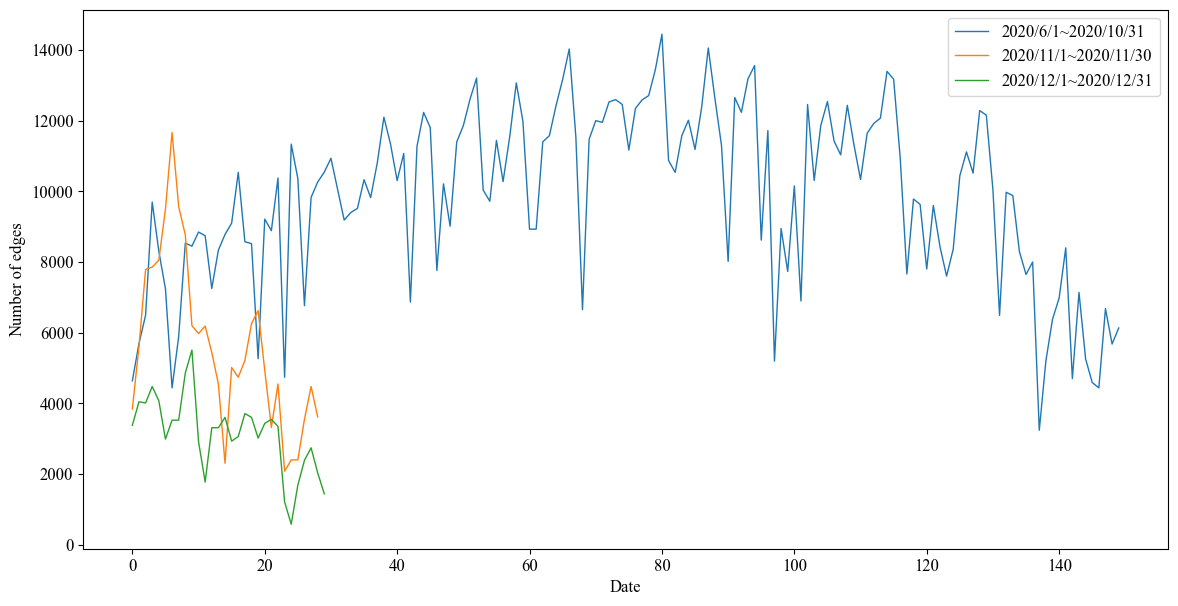

In [40]:
plt.figure(figsize=(14,7)) 
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(edge_202006_2020102, label="2020/6/1~2020/10/31", linewidth=1)
plt.plot(edge_2020112, label="2020/11/1~2020/11/30", linewidth=1)
plt.plot(edge_2020122, label="2020/12/1~2020/12/31", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Number of edges")
plt.legend()
plt.show()

In [16]:
# dfを2ヶ月ごとに分割する
df_202004_202005 = df[(df["started_at"] >= "2020-04-01") & (df["started_at"] <= "2020-05-31")]
df_202006_202007 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] <= "2020-07-31")]
df_202008_202009 = df[(df["started_at"] >= "2020-08-01") & (df["started_at"] <= "2020-09-30")]
df_202010_202011 = df[(df["started_at"] >= "2020-10-01") & (df["started_at"] <= "2020-11-30")]
df_202012_202101 = df[(df["started_at"] >= "2020-12-01") & (df["started_at"] <= "2021-01-31")]
df_202102_202103 = df[(df["started_at"] >= "2021-02-01") & (df["started_at"] <= "2021-03-31")]
df_202104_202105 = df[(df["started_at"] >= "2021-04-01") & (df["started_at"] <= "2021-05-31")]
df_202106_202107 = df[(df["started_at"] >= "2021-06-01") & (df["started_at"] <= "2021-07-31")]
df_202108_202109 = df[(df["started_at"] >= "2021-08-01") & (df["started_at"] <= "2021-09-30")]
df_202110_202111 = df[(df["started_at"] >= "2021-10-01") & (df["started_at"] <= "2021-11-30")]
df_202112_202201 = df[(df["started_at"] >= "2021-12-01") & (df["started_at"] <= "2022-01-31")]
df_202202_202203 = df[(df["started_at"] >= "2022-02-01") & (df["started_at"] <= "2022-03-31")]
df_202204_202205 = df[(df["started_at"] >= "2022-04-01") & (df["started_at"] <= "2022-05-31")]
df_202206_202207 = df[(df["started_at"] >= "2022-06-01") & (df["started_at"] <= "2022-07-31")]
df_202208_202209 = df[(df["started_at"] >= "2022-08-01") & (df["started_at"] <= "2022-09-30")]
df_202210_202211 = df[(df["started_at"] >= "2022-10-01") & (df["started_at"] <= "2022-11-30")]
df_202212_202301 = df[(df["started_at"] >= "2022-12-01") & (df["started_at"] <= "2023-01-31")]
df_202302_202303 = df[(df["started_at"] >= "2023-02-01") & (df["started_at"] <= "2023-03-31")]
df_202304_202305 = df[(df["started_at"] >= "2023-04-01") & (df["started_at"] <= "2023-05-31")]
df_202306_202307 = df[(df["started_at"] >= "2023-06-01") & (df["started_at"] <= "2023-07-31")]
df_202308_202309 = df[(df["started_at"] >= "2023-08-01") & (df["started_at"] <= "2023-09-30")]

In [8]:
df.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [9]:
df_list_2month = [df_lockdown, df_202006_202007, df_202008_202009, df_202010_202011, df_202012_202101, df_202102_202103, df_202104_202105, df_202106_202107, df_202108_202109, df_202110_202111, df_202112_202201, df_202202_202203, df_202204_202205, df_202206_202207, df_202208_202209, df_202210_202211, df_202212_202301, df_202302_202303, df_202304_202305, df_202306_202307, df_202308_202309]

In [17]:
node_202004_202005, edge_202004_202005, timestamp_202004_202005 = getNetworkAnalysis(df_202004_202005)
node_202006_202007, edge_202006_202007, timestamp_202006_202007 = getNetworkAnalysis(df_202006_202007)
node_202008_202009, edge_202008_202009, timestamp_202008_202009 = getNetworkAnalysis(df_202008_202009)
node_202010_202011, edge_202010_202011, timestamp_202010_202011 = getNetworkAnalysis(df_202010_202011)
node_202012_202101, edge_202012_202101, timestamp_202012_202101 = getNetworkAnalysis(df_202012_202101)
node_202102_202103, edge_202102_202103, timestamp_202102_202103 = getNetworkAnalysis(df_202102_202103)
node_202104_202105, edge_202104_202105, timestamp_202104_202105 = getNetworkAnalysis(df_202104_202105)
node_202106_202107, edge_202106_202107, timestamp_202106_202107 = getNetworkAnalysis(df_202106_202107)
node_202108_202109, edge_202108_202109, timestamp_202108_202109 = getNetworkAnalysis(df_202108_202109)
node_202110_202111, edge_202110_202111, timestamp_202110_202111 = getNetworkAnalysis(df_202110_202111)
node_202112_202201, edge_202112_202201, timestamp_202112_202201 = getNetworkAnalysis(df_202112_202201)
node_202202_202203, edge_202202_202203, timestamp_202202_202203 = getNetworkAnalysis(df_202202_202203)
node_202204_202205, edge_202204_202205, timestamp_202204_202205 = getNetworkAnalysis(df_202204_202205)
node_202206_202207, edge_202206_202207, timestamp_202206_202207 = getNetworkAnalysis(df_202206_202207)
node_202208_202209, edge_202208_202209, timestamp_202208_202209 = getNetworkAnalysis(df_202208_202209)
node_202210_202211, edge_202210_202211, timestamp_202210_202211 = getNetworkAnalysis(df_202210_202211)
node_202212_202301, edge_202212_202301, timestamp_202212_202301 = getNetworkAnalysis(df_202212_202301)
node_202302_202303, edge_202302_202303, timestamp_202302_202303 = getNetworkAnalysis(df_202302_202303)
node_202304_202305, edge_202304_202305, timestamp_202304_202305 = getNetworkAnalysis(df_202304_202305)
node_202306_202307, edge_202306_202307, timestamp_202306_202307 = getNetworkAnalysis(df_202306_202307)
node_202308_202309, edge_202308_202309, timestamp_202308_202309 = getNetworkAnalysis(df_202308_202309)

In [14]:
Np_list = [596, 596, 673, 673, 677, 677, 677, 846, 846, 846, 846, 846, 1416, 1416, 1416, 1416, 1416, 1416, 1416, 1416, 1416]
print(len(Np_list))

21


In [18]:
alpha_list2 = []
beta_list2 = []
df_list_2month = [df_lockdown, df_202006_202007, df_202008_202009, df_202010_202011, df_202012_202101, df_202102_202103, df_202104_202105, df_202106_202107, df_202108_202109, df_202110_202111, df_202112_202201, df_202202_202203, df_202204_202205, df_202206_202207, df_202208_202209, df_202210_202211, df_202212_202301, df_202302_202303, df_202304_202305, df_202306_202307, df_202308_202309]
node_list2 = [node_202004_202005, node_202006_202007, node_202008_202009, node_202010_202011, node_202012_202101, node_202102_202103, node_202104_202105, node_202106_202107, node_202108_202109, node_202110_202111, node_202112_202201, node_202202_202203, node_202204_202205, node_202206_202207, node_202208_202209, node_202210_202211, node_202212_202301, node_202302_202303, node_202304_202305, node_202306_202307, node_202308_202309]
edge_list2 = [edge_202004_202005, edge_202006_202007, edge_202008_202009, edge_202010_202011, edge_202012_202101, edge_202102_202103, edge_202104_202105, edge_202106_202107, edge_202108_202109, edge_202110_202111, edge_202112_202201, edge_202202_202203, edge_202204_202205, edge_202206_202207, edge_202208_202209, edge_202210_202211, edge_202212_202301, edge_202302_202303, edge_202304_202305, edge_202306_202307, edge_202308_202309]

print(len(df_list_2month))
print(len(node_list2))
print(len(edge_list2))


21
21
21


In [19]:
for i in range(len(node_list2)):
    Np = Np_list[i]
    N = node_list2[i]
    M = edge_list2[i]
    params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
    alpha_list2.append(params[0])
    beta_list2.append(params[1])

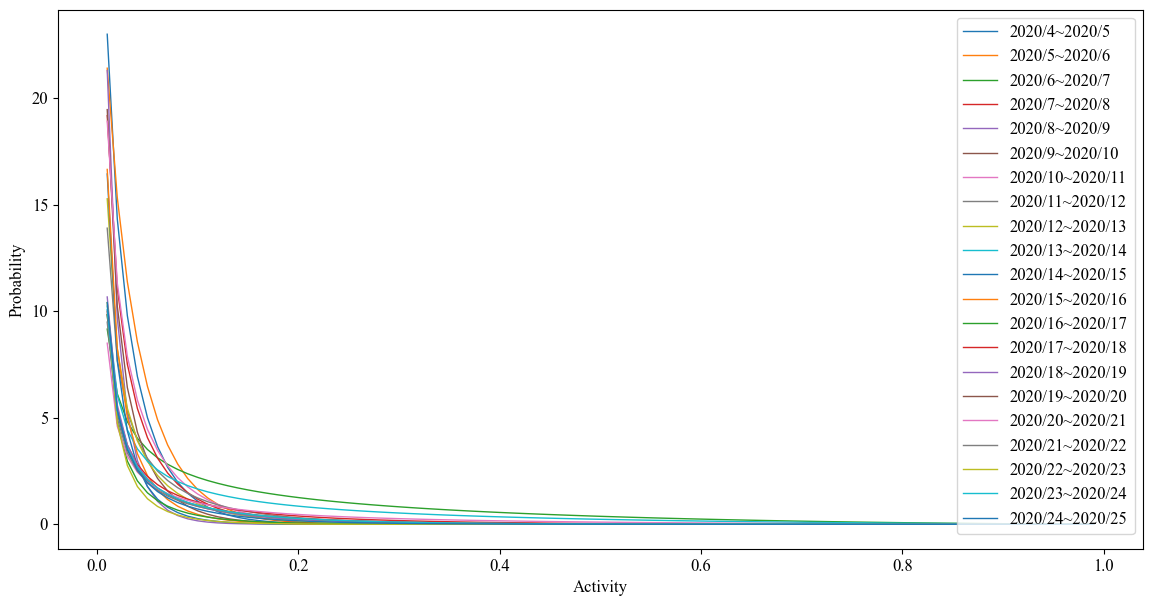

In [34]:
# activity distribution
a = np.arange(0, 1, 0.01)
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

for i in range(len(df_list_2month)):
    plt.plot(a, rho(a, alpha_list2[i], beta_list2[i]), label=f"2020/{i+4}~2020/{i+5}", linewidth=1)
plt.xlabel("Activity")
plt.ylabel("Probability")
plt.legend()
plt.savefig("../fig/alpha_beta_2month.png")
plt.show()


In [22]:
kappa_202004_202005 = []
for i in range(len(edge_202004_202005)):
    alpha = alpha_list2[0]
    beta = beta_list2[0]
    Np = Np_list[0]
    kappa_202004_202005.append(kappa(edge_202004_202005[i], Np))

kappa_202006_202007 = []
for i in range(len(edge_202006_202007)):
    alpha = alpha_list2[1]
    beta = beta_list2[1]
    Np = Np_list[1]
    kappa_202006_202007.append(kappa(edge_202006_202007[i], Np))

kappa_202008_202009 = []
for i in range(len(edge_202008_202009)):
    alpha = alpha_list2[2]
    beta = beta_list2[2]
    Np = Np_list[2]
    kappa_202008_202009.append(kappa(edge_202008_202009[i], Np))

kappa_202010_202011 = []
for i in range(len(edge_202010_202011)):
    alpha = alpha_list2[3]
    beta = beta_list2[3]
    Np = Np_list[3]
    kappa_202010_202011.append(kappa(edge_202010_202011[i], Np))

kappa_202012_202101 = []
for i in range(len(edge_202012_202101)):
    alpha = alpha_list2[4]
    beta = beta_list2[4]
    Np = Np_list[4]
    kappa_202012_202101.append(kappa(edge_202012_202101[i], Np))

kappa_202102_202103 = []
for i in range(len(edge_202102_202103)):
    alpha = alpha_list2[5]
    beta = beta_list2[5]
    Np = Np_list[5]
    kappa_202102_202103.append(kappa(edge_202102_202103[i], Np))

kappa_202104_202105 = []
for i in range(len(edge_202104_202105)):
    alpha = alpha_list2[6]
    beta = beta_list2[6]
    Np = Np_list[6]
    kappa_202104_202105.append(kappa(edge_202104_202105[i], Np))

kappa_202106_202107 = []
for i in range(len(edge_202106_202107)):
    alpha = alpha_list2[7]
    beta = beta_list2[7]
    Np = Np_list[7]
    kappa_202106_202107.append(kappa(edge_202106_202107[i], Np))

kappa_202108_202109 = []
for i in range(len(edge_202108_202109)):
    alpha = alpha_list2[8]
    beta = beta_list2[8]
    Np = Np_list[8]
    kappa_202108_202109.append(kappa(edge_202108_202109[i], Np))

kappa_202110_202111 = []
for i in range(len(edge_202110_202111)):
    alpha = alpha_list2[9]
    beta = beta_list2[9]
    Np = Np_list[9]
    kappa_202110_202111.append(kappa(edge_202110_202111[i], Np))

kappa_202112_202201 = []
for i in range(len(edge_202112_202201)):
    alpha = alpha_list2[10]
    beta = beta_list2[10]
    Np = Np_list[10]
    kappa_202112_202201.append(kappa(edge_202112_202201[i], Np))

kappa_202202_202203 = []
for i in range(len(edge_202202_202203)):
    alpha = alpha_list2[11]
    beta = beta_list2[11]
    Np = Np_list[11]
    kappa_202202_202203.append(kappa(edge_202202_202203[i], Np))

kappa_202204_202205 = []
for i in range(len(edge_202204_202205)):
    alpha = alpha_list2[12]
    beta = beta_list2[12]
    Np = Np_list[12]
    kappa_202204_202205.append(kappa(edge_202204_202205[i], Np))

kappa_202206_202207 = []
for i in range(len(edge_202206_202207)):
    alpha = alpha_list2[13]
    beta = beta_list2[13]
    Np = Np_list[13]
    kappa_202206_202207.append(kappa(edge_202206_202207[i], Np))

kappa_202208_202209 = []
for i in range(len(edge_202208_202209)):
    alpha = alpha_list2[14]
    beta = beta_list2[14]
    Np = Np_list[14]
    kappa_202208_202209.append(kappa(edge_202208_202209[i], Np))

kappa_202210_202211 = []
for i in range(len(edge_202210_202211)):
    alpha = alpha_list2[15]
    beta = beta_list2[15]
    Np = Np_list[15]
    kappa_202210_202211.append(kappa(edge_202210_202211[i], Np))

kappa_202212_202301 = []
for i in range(len(edge_202212_202301)):
    alpha = alpha_list2[16]
    beta = beta_list2[16]
    Np = Np_list[16]
    kappa_202212_202301.append(kappa(edge_202212_202301[i], Np))

kappa_202302_202303 = []
for i in range(len(edge_202302_202303)):
    alpha = alpha_list2[17]
    beta = beta_list2[17]
    Np = Np_list[17]
    kappa_202302_202303.append(kappa(edge_202302_202303[i], Np))

kappa_202304_202305 = []
for i in range(len(edge_202304_202305)):
    alpha = alpha_list2[18]
    beta = beta_list2[18]
    Np = Np_list[18]
    kappa_202304_202305.append(kappa(edge_202304_202305[i], Np))

kappa_202306_202307 = []
for i in range(len(edge_202306_202307)):
    alpha = alpha_list2[19]
    beta = beta_list2[19]
    Np = Np_list[19]
    kappa_202306_202307.append(kappa(edge_202306_202307[i], Np))

kappa_202308_202309 = []
for i in range(len(edge_202308_202309)):
    alpha = alpha_list2[20]
    beta = beta_list2[20]
    Np = Np_list[20]
    kappa_202308_202309.append(kappa(edge_202308_202309[i], Np))

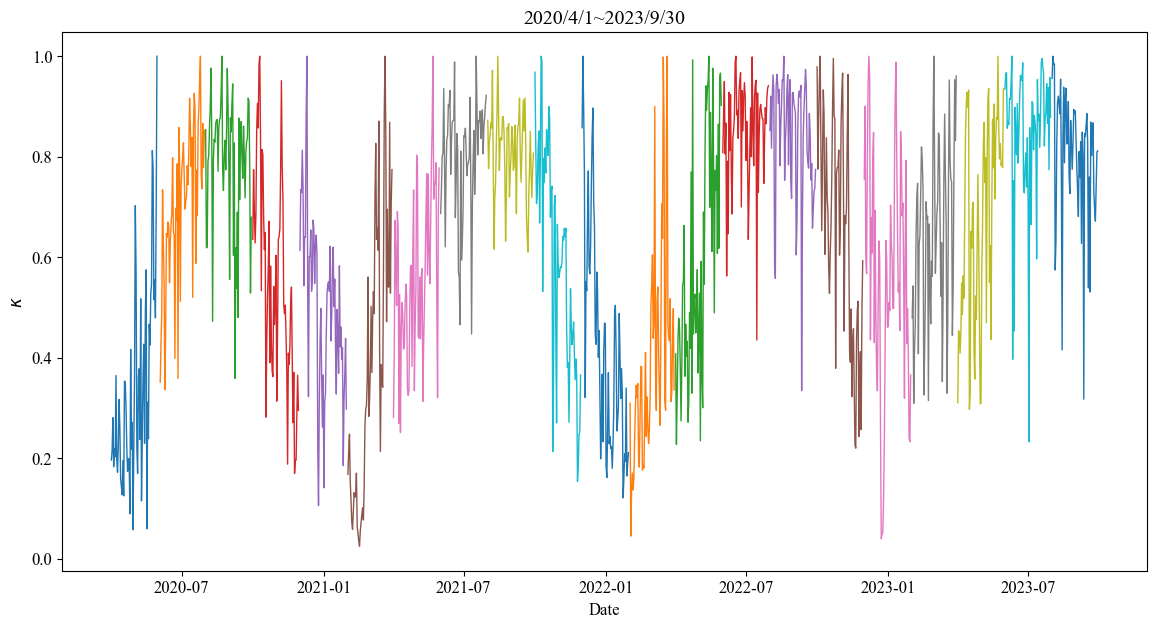

In [33]:
# kappaを重ねてみる
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

kappa_list2 = [kappa_202004_202005, kappa_202006_202007, kappa_202008_202009, kappa_202010_202011, kappa_202012_202101, kappa_202102_202103, kappa_202104_202105, kappa_202106_202107, kappa_202108_202109, kappa_202110_202111, kappa_202112_202201, kappa_202202_202203, kappa_202204_202205, kappa_202206_202207, kappa_202208_202209, kappa_202210_202211, kappa_202212_202301, kappa_202302_202303, kappa_202304_202305, kappa_202306_202307, kappa_202308_202309]
timestamp_list2 = [timestamp_202004_202005, timestamp_202006_202007, timestamp_202008_202009, timestamp_202010_202011, timestamp_202012_202101, timestamp_202102_202103, timestamp_202104_202105, timestamp_202106_202107, timestamp_202108_202109, timestamp_202110_202111, timestamp_202112_202201, timestamp_202202_202203, timestamp_202204_202205, timestamp_202206_202207, timestamp_202208_202209, timestamp_202210_202211, timestamp_202212_202301, timestamp_202302_202303, timestamp_202304_202305, timestamp_202306_202307, timestamp_202308_202309]

for i in range(len(kappa_list2)):
    plt.plot(timestamp_list2[i], kappa_list2[i]/np.max(kappa_list2[i]), label=f"2020/{i+4}~2020/{i+5}", linewidth=1)

# lockdownの上限と下限の値で線を引く
#plt.axhline(y=np.min(kappa_202004_202005), color="blue", linestyle="--", linewidth=1, label="kappa's lower bound when lockdown occurs")
#plt.axhline(y=np.max(kappa_202004_202005), color="red", linestyle="-", linewidth=1, label="kappa's upper bound when lockdown occurs")


plt.xlabel("Date")
plt.ylabel(r"$\kappa$")
plt.title("2020/4/1~2023/9/30")
# plt.legend()
plt.savefig("../fig/kappa_2month.png")
plt.show()



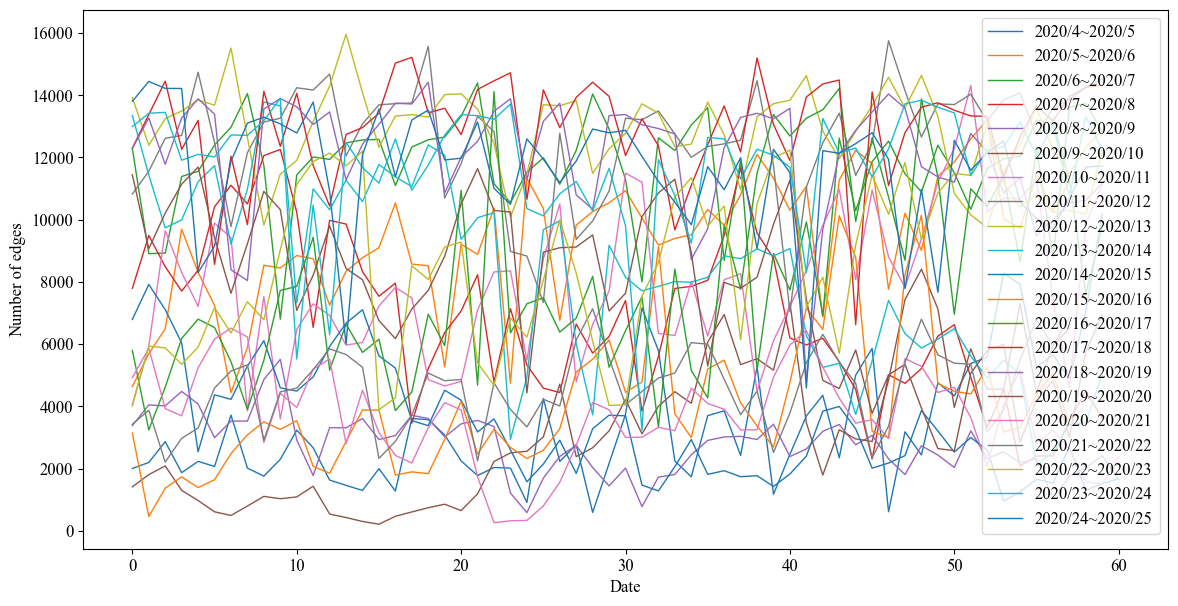

In [28]:
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

for i in range(len(edge_list2)):
    plt.plot(edge_list2[i], label=f"2020/{i+4}~2020/{i+5}", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Number of edges")
plt.legend()
plt.show()

In [9]:
# dfを2021年から2023年のデータセットに分ける
df_2021_2023 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] <= "2023-09-30")]
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] <= "2021-12-31")]
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] <= "2022-12-31")]
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] <= "2023-09-30")]

In [12]:
df_2022_2023 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] <= "2023-09-30")]

In [22]:
node_2021, edge_2021, timestamp_2021 = getNetworkAnalysis(df_2021)
node_2022_2023, edge_2022_2023, timestamp_2022_2023 = getNetworkAnalysis(df_2022_2023)

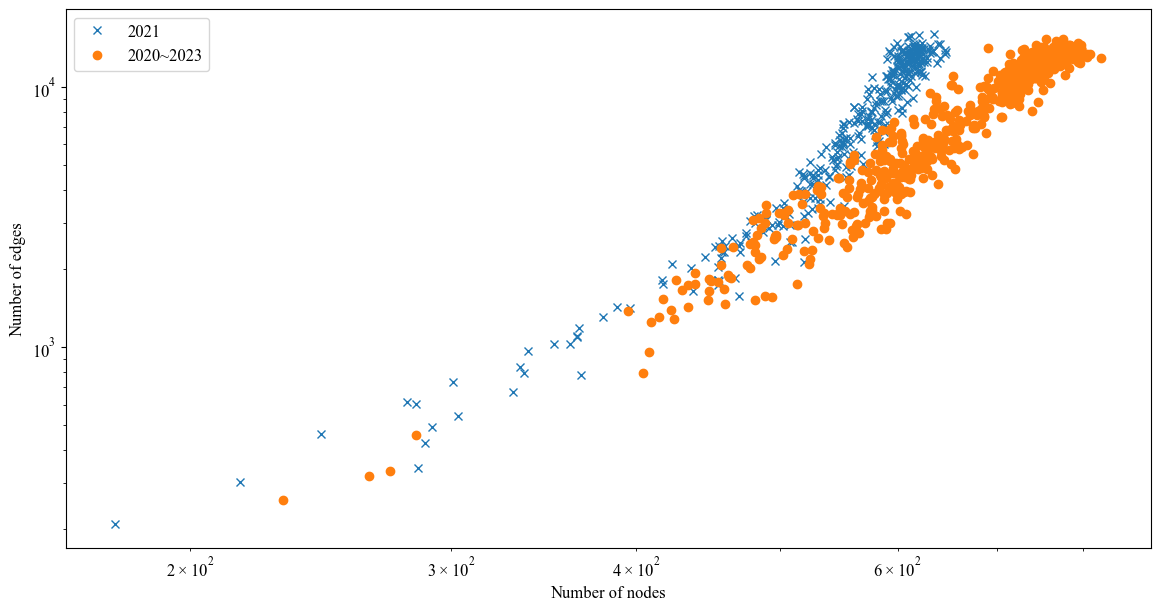

In [29]:
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(node_2021, edge_2021, "x", label="2021")
plt.plot(node_2022_2023, edge_2022_2023, "o", label="2020~2023")
plt.xlabel("Number of nodes")
plt.ylabel("Number of edges")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

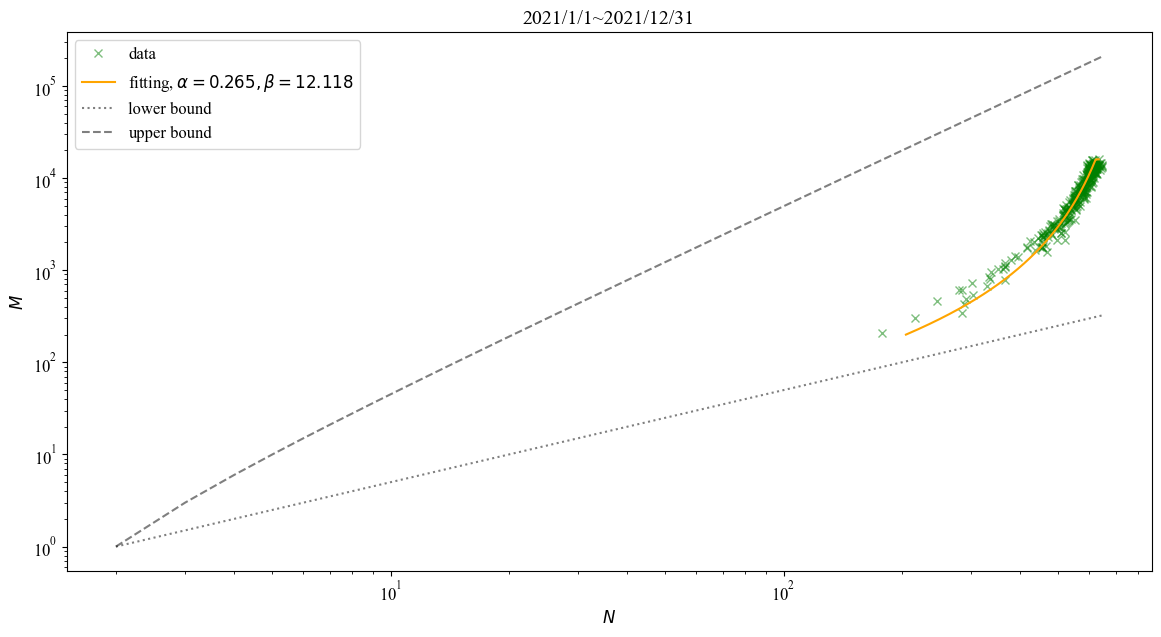

In [15]:
# 2021年のデータについて、alphaとbetaを推定する
Np = 846
N = node_2021
M = edge_2021
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

# kappaを求める
kappa_2021 = []
for i in range(len(edge_2021)):
    kappa_2021.append(kappa(edge_2021[i], Np))

# 2021年のデータをプロット
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
plt.title("2021/1/1~2021/12/31")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

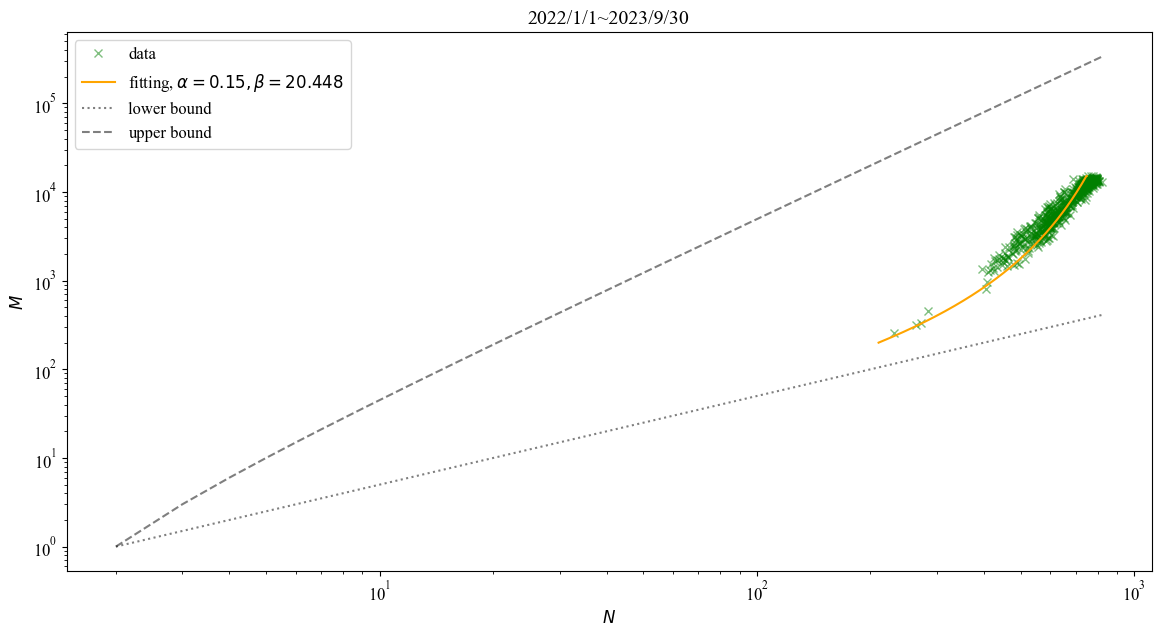

In [25]:
# 2022, 2023年のデータについて、alphaとbetaを推定する
Np = 1416
N = node_2022_2023
M = edge_2022_2023
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

# kappaを求める
kappa_2022_2023 = []
for i in range(len(edge_2022_2023)):
    kappa_2022_2023.append(kappa(edge_2022_2023[i], Np))

# 2021年のデータをプロット
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
plt.title("2022/1/1~2023/9/30")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

In [26]:
alpha_list = [0.265, 12.118]
beta_list = [0.15, 20.448]

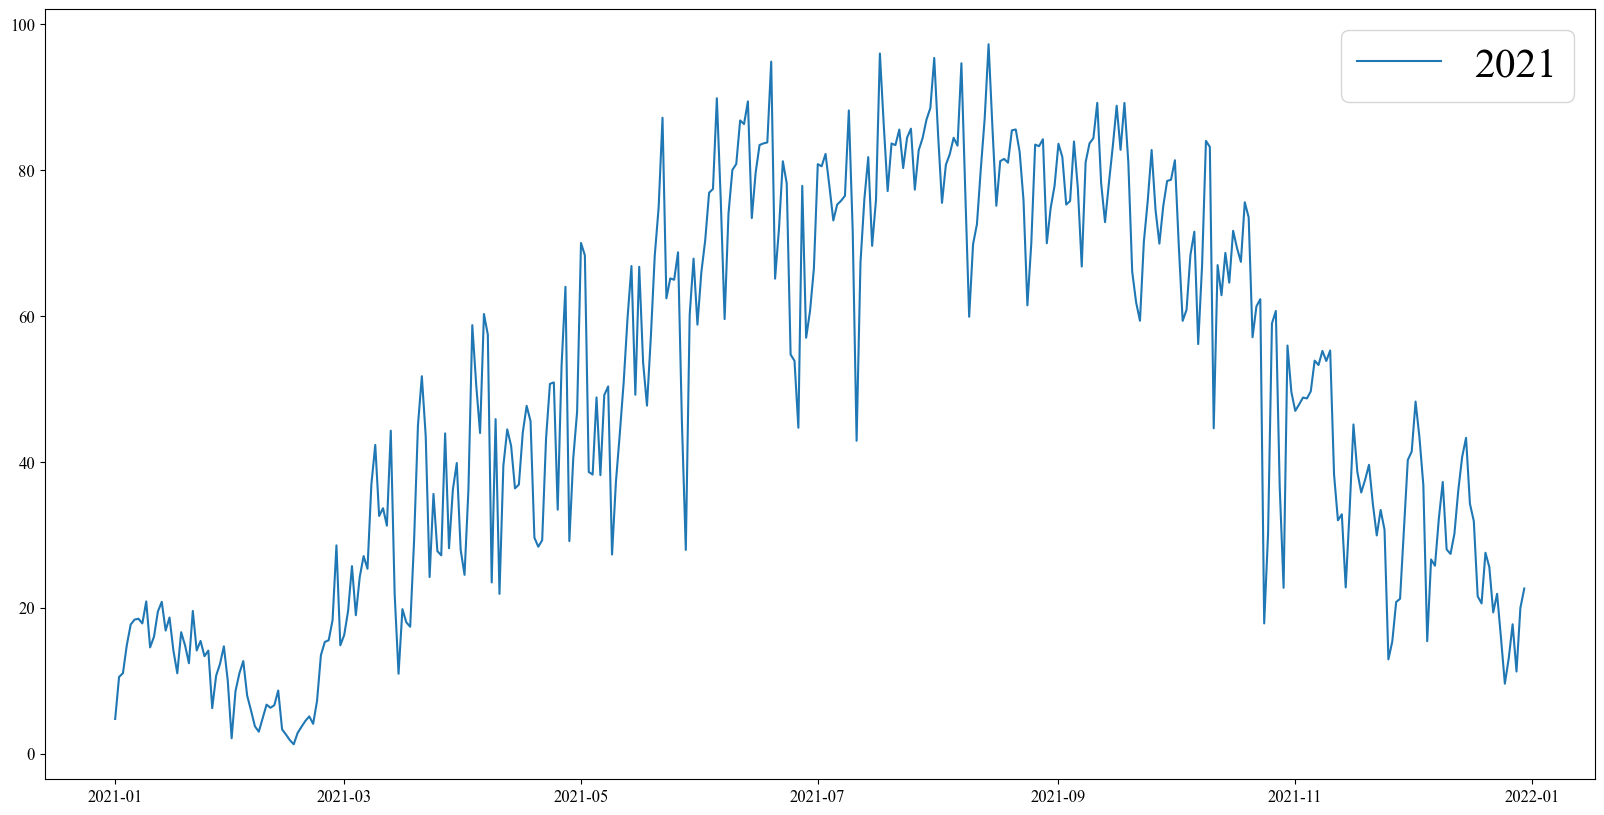

In [37]:
# kappa_2021をプロットする
plt.figure(figsize=(20, 10))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(timestamp_2021, kappa_2021, label="2021")

# plt.xlabel("Date")
# plt.ylabel(r"$\kappa$")
# legendのサイズを大きくする
plt.legend(prop={"size": 30})
plt.show()

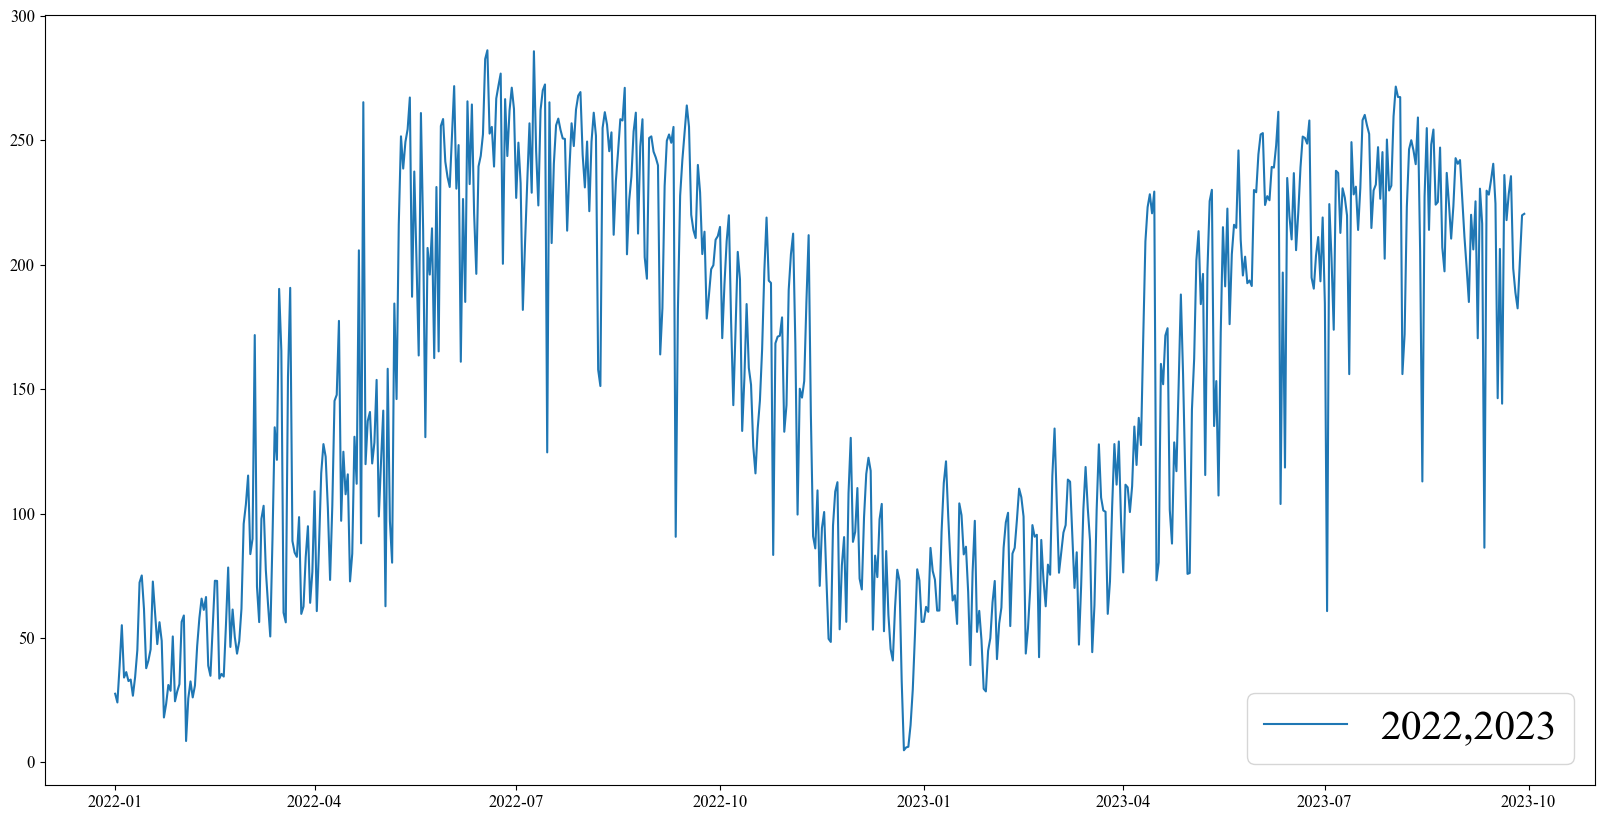

In [39]:
# kappa_2022_2023をプロットする
plt.figure(figsize=(20, 10))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(timestamp_2022_2023, kappa_2022_2023, label="2022,2023")

# plt.xlabel("Date")
# plt.ylabel(r"$\kappa$")
# plt.legend()
plt.legend(prop={"size": 30})
plt.show()

In [30]:
kappa_df = pd.DataFrame({"timestamp": timestamp_2021, "kappa": kappa_2021})
kappa_df.to_csv("../data/kappa_2021.csv", index=False)

kappa_df = pd.DataFrame({"timestamp": timestamp_2022_2023, "kappa": kappa_2022_2023})
kappa_df.to_csv("../data/kappa_2022_2023.csv", index=False)

In [24]:
print(len(kappa_2022_2023))

364
